In [1]:
%reset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-12-01 19:08:19.760553: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 19:08:19.795204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 19:08:19.795261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 19:08:19.796451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 19:08:19.802124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 19:08:19.802502: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Dataset 1a : MLFFNN

In [2]:
Xtrain = pd.read_csv('dataset 1a/Train-14.csv')[['input1','input2']]
ytrain = pd.read_csv('dataset 1a/Train-14.csv')[['output']]

Xval  = pd.read_csv('dataset 1a/Val-14.csv')[['input1','input2']]
yval  = pd.read_csv('dataset 1a/Val-14.csv')[['output']]

Xtest = pd.read_csv('dataset 1a/Test-14.csv')[['input1','input2']]
ytest = pd.read_csv('dataset 1a/Test-14.csv')[['output']]

In [3]:
def separate(x,y) :

    class0 = np.array([0,0])
    class1 = np.array([0,0])

    for i in range(len(y)) :
        if y[i,0] == 0 :
            class0 = np.vstack((class0,x[i,:]))
        elif y[i,0] == 1 :
            class1 = np.vstack((class1,x[i,:]))

    class0 = np.delete(class0, 0, axis=0)
    class1 = np.delete(class1, 0, axis=0)

    return class0, class1

In [4]:
class0, class1 = separate(Xtrain.to_numpy(),ytrain.to_numpy())

In [5]:
def plot_node_output(node, node_index, node_name, plt_title, elev=20, yaw=-30) : 
    X = np.linspace(-5,5, 250)
    Y = np.linspace(-10,4,250)
    # X = np.linspace(-20,20, 300)
    # Y = np.linspace(-20,20, 300)
    Xgrid, Ygrid = np.meshgrid(X,Y)
    XYgrid = np.column_stack([Xgrid.flatten(), Ygrid.flatten()])
    activation_value = node.predict(XYgrid)
    activation_grid = activation_value[:,node_index].reshape(Xgrid.shape)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    if node_name == 'output':
        #ax.scatter(Xtrain['input1'], Xtrain['input2'], ytrain, marker='+', color='black')
        ax.scatter(class0[:,0], class0[:,1], np.zeros((len(class0),1)), marker='+', color='black')
        ax.scatter(class1[:,0], class1[:,1], np.ones((len(class1),1)), marker='+', color='blue')
        ax.legend(['class0','class1'])

    ax.plot_surface(Xgrid, Ygrid, activation_grid, cmap='RdYlBu',alpha=0.8)

    ax.set_title(plt_title)
    ax.set_xlabel('input 1')
    ax.set_ylabel('input 2')
    ax.set_zlabel('Node Output')
    ax.grid(True)
    ax.set_xlim(-5,5)
    ax.set_ylim(-10,4)
    # ax.set_xlim(-20,20)
    # ax.set_ylim(-20,20)
    ax.view_init(elev=elev, azim=yaw)
    plt.savefig(f"{plt_title}.png",dpi=260)
    plt.show()

## Perceptron : 

Epoch 1/30
360/360 [==============================] - 1s 1ms/step - loss: 0.2203 - binary_accuracy: 0.8944 - val_loss: 0.1540 - val_binary_accuracy: 0.9222
Epoch 2/30
360/360 [==============================] - 0s 997us/step - loss: 0.1445 - binary_accuracy: 0.9472 - val_loss: 0.1076 - val_binary_accuracy: 0.9667
Epoch 3/30
360/360 [==============================] - 0s 1ms/step - loss: 0.1088 - binary_accuracy: 0.9694 - val_loss: 0.0848 - val_binary_accuracy: 0.9778
Epoch 4/30
360/360 [==============================] - 0s 1ms/step - loss: 0.0893 - binary_accuracy: 0.9806 - val_loss: 0.0716 - val_binary_accuracy: 0.9889
Epoch 5/30
360/360 [==============================] - 0s 1ms/step - loss: 0.0770 - binary_accuracy: 0.9833 - val_loss: 0.0627 - val_binary_accuracy: 1.0000
Epoch 6/30
360/360 [==============================] - 0s 1ms/step - loss: 0.0681 - binary_accuracy: 0.9917 - val_loss: 0.0560 - val_binary_accuracy: 1.0000
Epoch 7/30
360/360 [==============================] - 0s 1ms/s

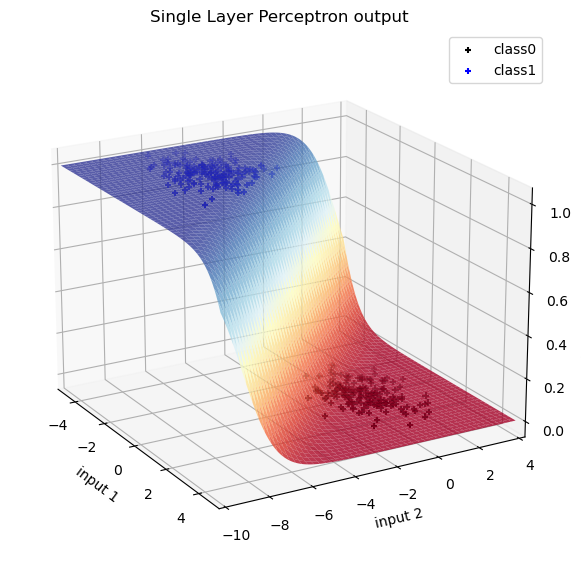

----------------------------------------------------------------------------------------------------------------------------------------


In [19]:
def custom_activation(x) :
    return tf.where(x>=0, 1, -1)

model = Sequential()
model.add(Dense(units=1, input_dim = 2, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.fit(Xtrain, ytrain, epochs=30, batch_size=1, validation_data=(Xval,yval))
print('Actual test begins here', model.evaluate(Xtest, ytest))
output_node = tf.keras.models.Model(inputs=model.input, outputs=model.layers[0].output)

plot_node_output(output_node, 0,'output', f"Single Layer Perceptron output")
print('----------------------------------------------------------------------------------------------------------------------------------------')

In [21]:
np.count_nonzero(ytrain)

178

## MLFFNN

Epoch 1/3
360/360 [==============================] - 1s 1ms/step - loss: 0.6472 - binary_accuracy: 0.6167 - val_loss: 0.5024 - val_binary_accuracy: 0.8111
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.3942 - binary_accuracy: 0.9056 - val_loss: 0.2793 - val_binary_accuracy: 0.9556
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.1652 - binary_accuracy: 1.0000
Actual test begins here [0.16519096493721008, 1.0]
1954/1954 [==============================] - 1s 747us/step


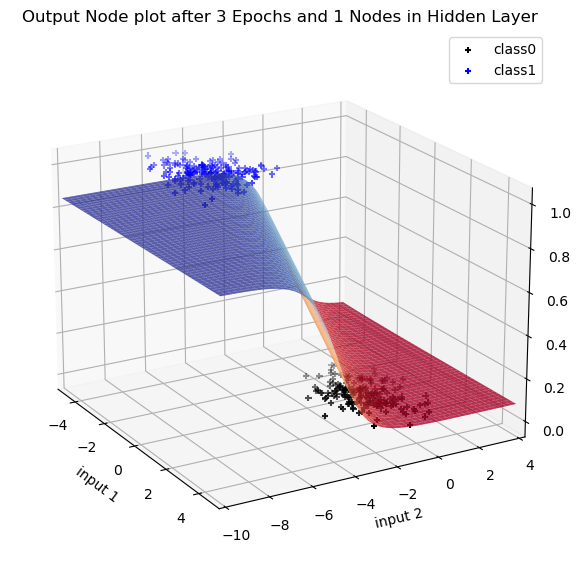

----------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/3
360/360 [==============================] - 1s 1ms/step - loss: 0.3662 - binary_accuracy: 0.8639 - val_loss: 0.2241 - val_binary_accuracy: 0.9667
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.1602 - binary_accuracy: 0.9889 - val_loss: 0.1133 - val_binary_accuracy: 1.0000
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.0746 - binary_accuracy: 1.0000
Actual test begins here [0.07464195042848587, 1.0]
1954/1954 [==============================] - 1s 733us/step


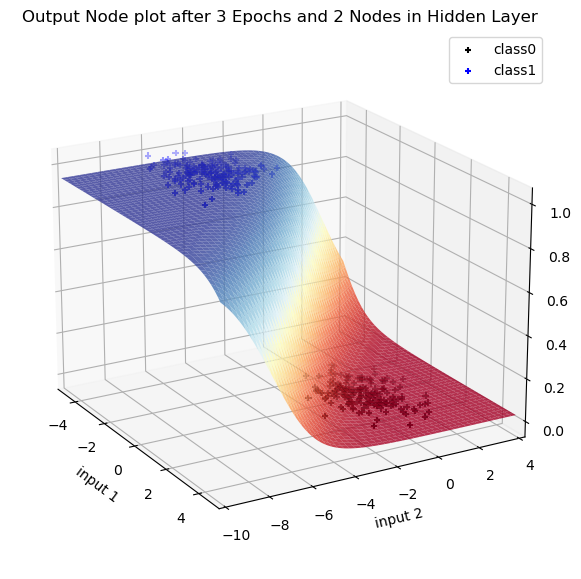

----------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/3
360/360 [==============================] - 1s 1ms/step - loss: 0.2755 - binary_accuracy: 0.9306 - val_loss: 0.1850 - val_binary_accuracy: 0.9667
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.1544 - binary_accuracy: 0.9694 - val_loss: 0.1101 - val_binary_accuracy: 0.9778
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.0673 - binary_accuracy: 1.0000
Actual test begins here [0.0673171654343605, 1.0]
1954/1954 [==============================] - 2s 766us/step


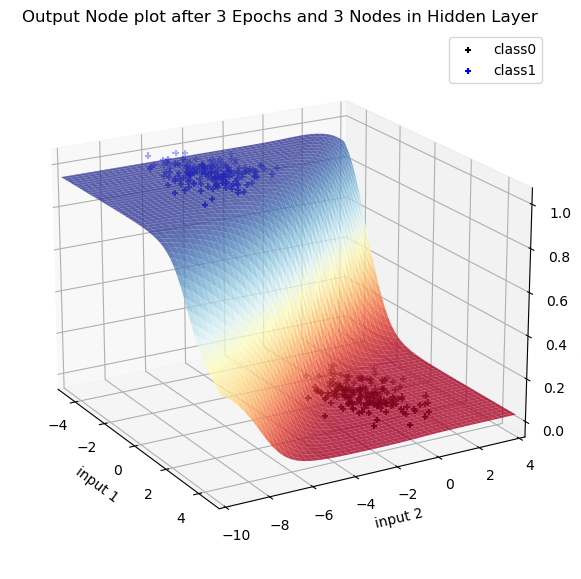

----------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/3
360/360 [==============================] - 1s 1ms/step - loss: 0.4979 - binary_accuracy: 0.7306 - val_loss: 0.2310 - val_binary_accuracy: 0.9667
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.1709 - binary_accuracy: 0.9833 - val_loss: 0.1130 - val_binary_accuracy: 0.9889
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.0689 - binary_accuracy: 1.0000
Actual test begins here [0.06892702728509903, 1.0]
1954/1954 [==============================] - 1s 728us/step


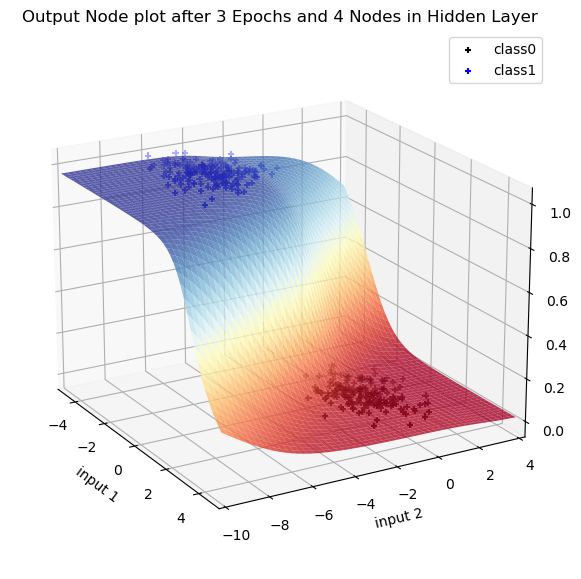

----------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/3
360/360 [==============================] - 1s 2ms/step - loss: 0.5309 - binary_accuracy: 0.7583 - val_loss: 0.2503 - val_binary_accuracy: 0.9667
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.1763 - binary_accuracy: 0.9944 - val_loss: 0.1190 - val_binary_accuracy: 1.0000
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.0747 - binary_accuracy: 1.0000
Actual test begins here [0.07471831142902374, 1.0]
1954/1954 [==============================] - 1s 734us/step


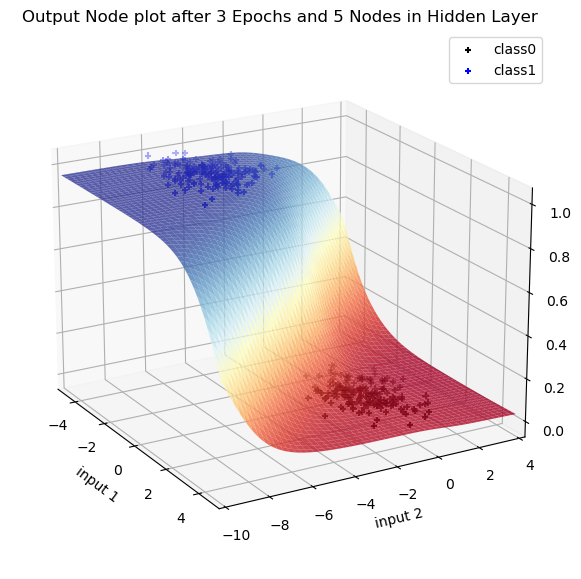

----------------------------------------------------------------------------------------------------------------------------------------


In [250]:
for i in [1,2,3,4,5]:
    model = Sequential()
    model.add(Dense(units=i, input_dim = 2, activation='tanh'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

    model.fit(Xtrain, ytrain, epochs=3, batch_size=1, validation_data=(Xval,yval))
    print('Actual test begins here', model.evaluate(Xtest, ytest))

    output_node = tf.keras.models.Model(inputs=model.input, outputs=model.layers[1].output)
    plot_node_output(output_node, 0,'output', f"Output Node plot after 3 Epochs and {i} Nodes in Hidden Layer")
    print('----------------------------------------------------------------------------------------------------------------------------------------')

Epoch 1/3
360/360 [==============================] - 1s 1ms/step - loss: 0.5824 - binary_accuracy: 0.7056 - val_loss: 0.2486 - val_binary_accuracy: 0.9222
Epoch 2/3
360/360 [==============================] - 0s 1ms/step - loss: 0.1575 - binary_accuracy: 0.9722 - val_loss: 0.1079 - val_binary_accuracy: 0.9667
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.0665 - binary_accuracy: 1.0000
Actual test begins here [0.06652066856622696, 1.0]
1954/1954 [==============================] - 1s 735us/step


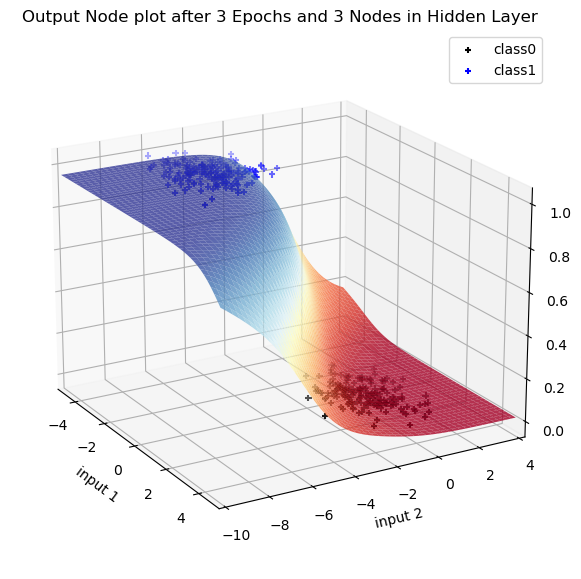

----------------------------------------------------------------------------------------------------------------------------------------


In [254]:
i = 3
model = Sequential()
model.add(Dense(units=i, input_dim = 2, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.fit(Xtrain, ytrain, epochs=3, batch_size=1, validation_data=(Xval,yval))
print('Actual test begins here', model.evaluate(Xtest, ytest))

output_node = tf.keras.models.Model(inputs=model.input, outputs=model.layers[1].output)
plot_node_output(output_node, 0,'output', f"Output Node plot after 3 Epochs and {i} Nodes in Hidden Layer")
print('----------------------------------------------------------------------------------------------------------------------------------------')

In [258]:
model.evaluate(Xtrain,ytrain)

12/12 [==============================] - 0s 1ms/step - loss: 0.0643 - binary_accuracy: 1.0000


[0.0643259584903717, 1.0]

In [261]:
predicted_output = np.vectorize(int)(model.predict(Xtest) > 0.5)
np.count_nonzero(ytest-predicted_output)

2/2 [==============================] - 0s 2ms/step


0

In [269]:
np.count_nonzero(ytest)

29

## Dataset 1b : MLFFNN

Requirements : 
* 2 hidden layers 
* Table of classification accuracies [ train & validation ] for various hyperparameter
* Classification accuracy for the best config of the model on test data
* Confusion matrix for the best config of the model [ train & test ]
* Decision region plots superposed with training dataset 
* For best classification of MLFFNN on 1b, plot the surfaces of the outputs of hidden layer nodes and output layer nodes after follwing epochs : 1,5,20,100 and after convergence

In [270]:
Xtrain = pd.read_csv('dataset 1b/Train-9.csv')[['x1','x2']]
ytrain = pd.read_csv('dataset 1b/Train-9.csv')[['label']]

Xval  = pd.read_csv('dataset 1b/Val-9.csv')[['x1','x2']]
yval  = pd.read_csv('dataset 1b/Val-9.csv')[['label']]

Xtest = pd.read_csv('dataset 1b/Test-9.csv')[['x1','x2']]
ytest = pd.read_csv('dataset 1b/Test-9.csv')[['label']]

class0, class1 = separate(Xtrain.to_numpy(),ytrain.to_numpy())

In [272]:
np.count_nonzero(ytest)

52

Hyperparameter : Number of Nodes :  5
Epoch Number : 500
Epoch 1/500
842/842 [==============================] - 2s 1ms/step - loss: 0.6456 - binary_accuracy: 0.6461 - val_loss: 0.5601 - val_binary_accuracy: 0.7227
Epoch 2/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5791 - binary_accuracy: 0.7126 - val_loss: 0.5352 - val_binary_accuracy: 0.7353
Epoch 3/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5606 - binary_accuracy: 0.7138 - val_loss: 0.5112 - val_binary_accuracy: 0.7395
Epoch 4/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5330 - binary_accuracy: 0.7447 - val_loss: 0.5308 - val_binary_accuracy: 0.7479
Epoch 5/500
842/842 [==============================] - 1s 1ms/step - loss: 0.4949 - binary_accuracy: 0.7803 - val_loss: 0.4473 - val_binary_accuracy: 0.8067
Epoch 6/500
842/842 [==============================] - 1s 1ms/step - loss: 0.4498 - binary_accuracy: 0.8124 - val_loss: 0.4291 - val_binary_accuracy: 0.7815
E

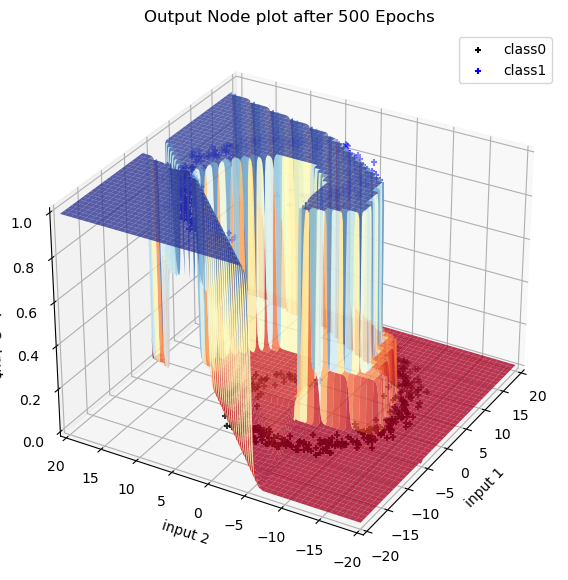

-----------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameter : Number of Nodes :  6
Epoch Number : 500
Epoch 1/500
842/842 [==============================] - 1s 1ms/step - loss: 0.6084 - binary_accuracy: 0.6960 - val_loss: 0.5492 - val_binary_accuracy: 0.7353
Epoch 2/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5705 - binary_accuracy: 0.7043 - val_loss: 0.5236 - val_binary_accuracy: 0.7353
Epoch 3/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5544 - binary_accuracy: 0.7078 - val_loss: 0.5222 - val_binary_accuracy: 0.7395
Epoch 4/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5355 - binary_accuracy: 0.7197 - val_loss: 0.5050 - val_binary_accuracy: 0.7395
Epoch 5/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5226 - binary_accuracy: 0.7090 - val_loss: 0.5470 - val_binary_accuracy: 0.7227
Epoch 6/

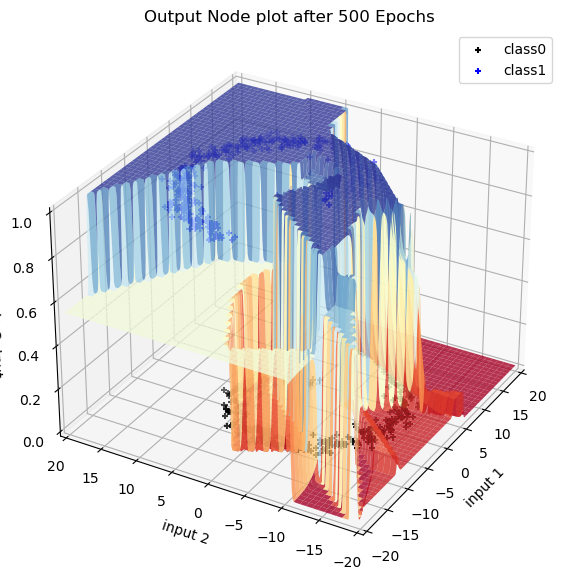

-----------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameter : Number of Nodes :  7
Epoch Number : 500
Epoch 1/500
842/842 [==============================] - 1s 1ms/step - loss: 0.6252 - binary_accuracy: 0.6413 - val_loss: 0.5755 - val_binary_accuracy: 0.6975
Epoch 2/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5666 - binary_accuracy: 0.6995 - val_loss: 0.5213 - val_binary_accuracy: 0.7227
Epoch 3/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5273 - binary_accuracy: 0.7221 - val_loss: 0.5007 - val_binary_accuracy: 0.7395
Epoch 4/500
842/842 [==============================] - 1s 1ms/step - loss: 0.4940 - binary_accuracy: 0.7577 - val_loss: 0.4695 - val_binary_accuracy: 0.7689
Epoch 5/500
842/842 [==============================] - 1s 1ms/step - loss: 0.4736 - binary_accuracy: 0.7732 - val_loss: 0.4220 - val_binary_accuracy: 0.8571
Epoch 6/

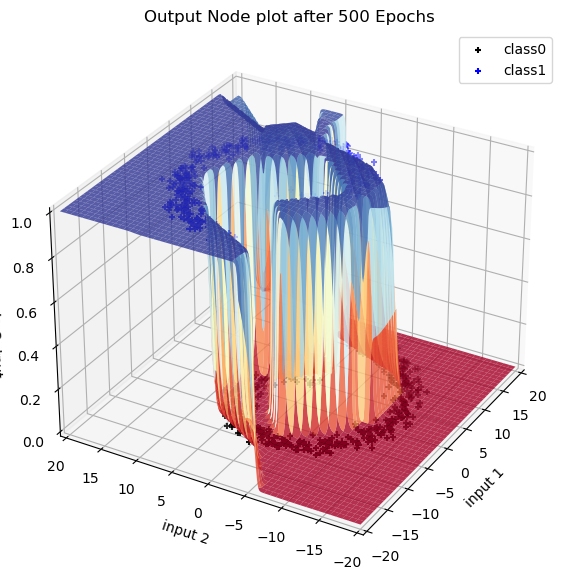

-----------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameter : Number of Nodes :  8
Epoch Number : 500
Epoch 1/500
842/842 [==============================] - 1s 1ms/step - loss: 0.6005 - binary_accuracy: 0.6746 - val_loss: 0.5487 - val_binary_accuracy: 0.7395
Epoch 2/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5547 - binary_accuracy: 0.6995 - val_loss: 0.5467 - val_binary_accuracy: 0.7311
Epoch 3/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5452 - binary_accuracy: 0.7067 - val_loss: 0.5342 - val_binary_accuracy: 0.7059
Epoch 4/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5298 - binary_accuracy: 0.7090 - val_loss: 0.5213 - val_binary_accuracy: 0.7101
Epoch 5/500
842/842 [==============================] - 1s 1ms/step - loss: 0.5203 - binary_accuracy: 0.7233 - val_loss: 0.5021 - val_binary_accuracy: 0.7185
Epoch 6/

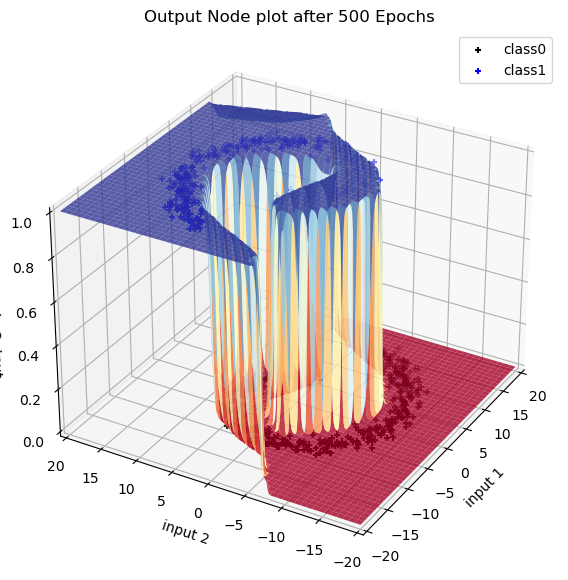

-----------------------------------------------------------------------------------------------------------------------------------------------------


In [164]:
for nodes in [5,6,7,8] : 
    i = 500
    print("Hyperparameter : Number of Nodes : ",nodes)

    model1 = Sequential()
    model1.add(Dense(units=nodes, input_dim = 2, activation='relu'))
    model1.add(Dense(units=nodes, activation='tanh'))
    model1.add(Dense(units=1, activation='sigmoid'))
    model1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    print(f"Epoch Number : {i}")
    model1.fit(Xtrain, ytrain, epochs=i, batch_size=1, validation_data=(Xval,yval)) 
    print('Actual test begins here : ',model1.evaluate(Xtest, ytest))
    output_node = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[2].output)
    hidden_node  = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[0].output)
    hidden_node1 = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[1].output)

    # plot_node_output(hidden_node, 0, (0,1),'hidden', f"First Hidden Layer Node 1 plot after {i} Epochs")
    # plot_node_output(hidden_node, 1, (0,1),'hidden', f"First Hidden Layer Node 2 plot after {i} Epochs")
    # plot_node_output(hidden_node, 2, (0,1),'hidden', f"First Hidden Layer Node 3 plot after {i} Epochs")
    # plot_node_output(hidden_node1, 0, (-1,1),'hidden', f"Second Hidden Layer Node 1 plot after {i} Epochs")
    # plot_node_output(hidden_node1, 1, (-1,1),'hidden', f"Second Hidden Layer Node 2 plot after {i} Epochs")
    # plot_node_output(hidden_node1, 2, (-1,1),'hidden', f"Second Hidden Layer Node 3 plot after {i} Epochs")
    plot_node_output(output_node, 0, (0,1) ,'output', f"Output Node plot after {i} Epochs",30,-150)
    print('-----------------------------------------------------------------------------------------------------------------------------------------------------')

In [235]:
nodes = 6
i = 100
print("Hyperparameter : Number of Nodes : ",nodes)

model1 = Sequential()
model1.add(Dense(units=nodes, input_dim = 2, activation='relu'))
model1.add(Dense(units=nodes, activation='tanh'))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


print(f"Epoch Number : {i}")
model1.fit(Xtrain, ytrain, epochs=i, batch_size=1, validation_data=(Xval,yval)) 
print('Actual test begins here : ',model1.evaluate(Xtest, ytest))
output_node = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[2].output)
hidden_node  = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[0].output)
hidden_node1 = tf.keras.models.Model(inputs=model1.input, outputs=model1.layers[1].output)

# plot_node_output(hidden_node, 0, (0,1),'hidden', f"First Hidden Layer Node 1 plot after {i} Epochs")
# plot_node_output(hidden_node, 1, (0,1),'hidden', f"First Hidden Layer Node 2 plot after {i} Epochs")
# plot_node_output(hidden_node, 2, (0,1),'hidden', f"First Hidden Layer Node 3 plot after {i} Epochs")
# plot_node_output(hidden_node1, 0, (-1,1),'hidden', f"Second Hidden Layer Node 1 plot after {i} Epochs")
# plot_node_output(hidden_node1, 1, (-1,1),'hidden', f"Second Hidden Layer Node 2 plot after {i} Epochs")
# plot_node_output(hidden_node1, 2, (-1,1),'hidden', f"Second Hidden Layer Node 3 plot after {i} Epochs")
# plot_node_output(output_node, 0, (0,1) ,'output', f"Output Node plot after {i} Epochs",30,-150)
print('-----------------------------------------------------------------------------------------------------------------------------------------------------')

Hyperparameter : Number of Nodes :  6
Epoch Number : 100
Epoch 1/100
842/842 [==============================] - 2s 1ms/step - loss: 0.6035 - binary_accuracy: 0.6853 - val_loss: 0.5447 - val_binary_accuracy: 0.7101
Epoch 2/100
842/842 [==============================] - 1s 1ms/step - loss: 0.5470 - binary_accuracy: 0.7055 - val_loss: 0.5068 - val_binary_accuracy: 0.7395
Epoch 3/100
842/842 [==============================] - 1s 1ms/step - loss: 0.5374 - binary_accuracy: 0.7090 - val_loss: 0.5870 - val_binary_accuracy: 0.6008
Epoch 4/100
842/842 [==============================] - 1s 1ms/step - loss: 0.5114 - binary_accuracy: 0.7292 - val_loss: 0.4749 - val_binary_accuracy: 0.7521
Epoch 5/100
842/842 [==============================] - 1s 1ms/step - loss: 0.4820 - binary_accuracy: 0.7565 - val_loss: 0.4337 - val_binary_accuracy: 0.8697
Epoch 6/100
842/842 [==============================] - 1s 1ms/step - loss: 0.4534 - binary_accuracy: 0.7803 - val_loss: 0.4244 - val_binary_accuracy: 0.8319
E

In [181]:
results = model1.predict(Xtest)

4/4 [==============================] - 0s 1ms/step


In [182]:
val = np.vectorize(int)(results > 0.5)

In [201]:
np.count_nonzero(val - ytest.to_numpy() < 0)

1

In [203]:
np.count_nonzero(model1.predict(Xtest)<0.5)

4/4 [==============================] - 0s 1ms/step


69

2813/2813 [==============================] - 2s 719us/step


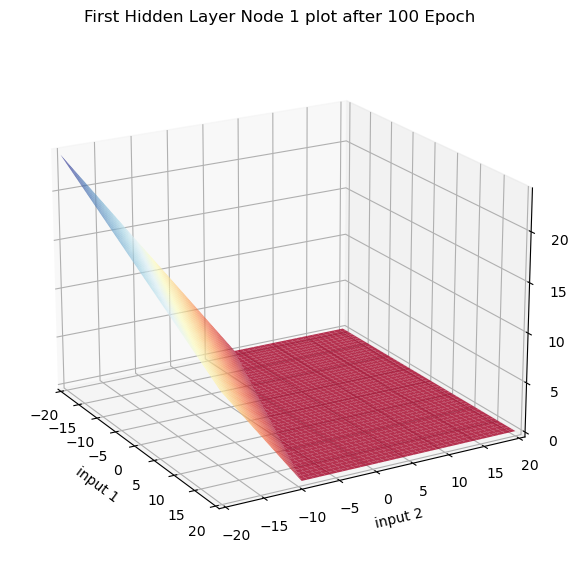

2813/2813 [==============================] - 2s 709us/step


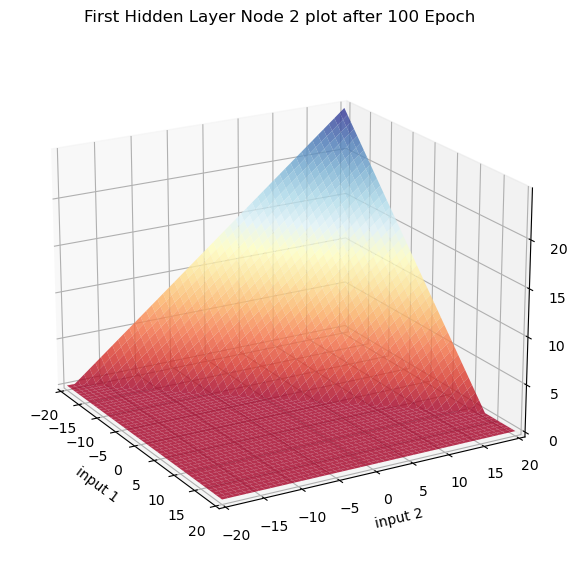

2813/2813 [==============================] - 2s 729us/step


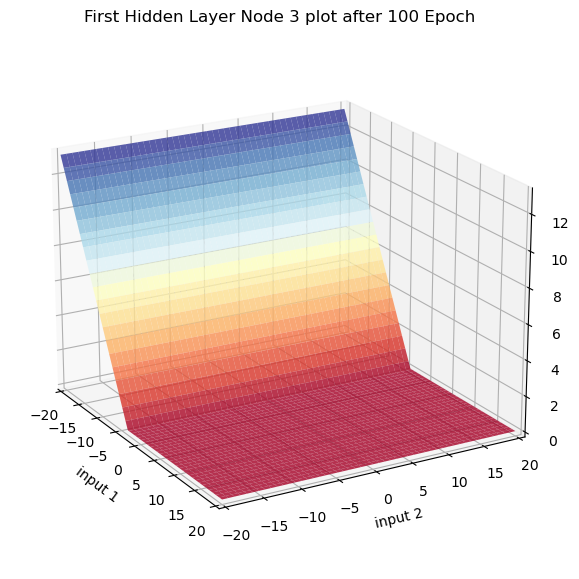

2813/2813 [==============================] - 2s 731us/step


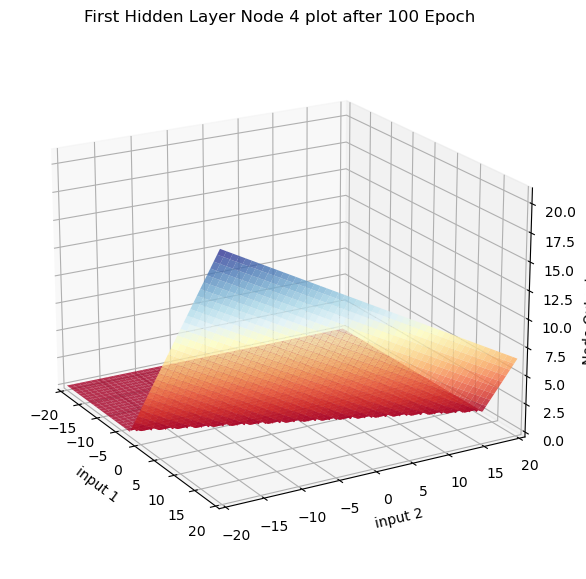

2813/2813 [==============================] - 2s 713us/step


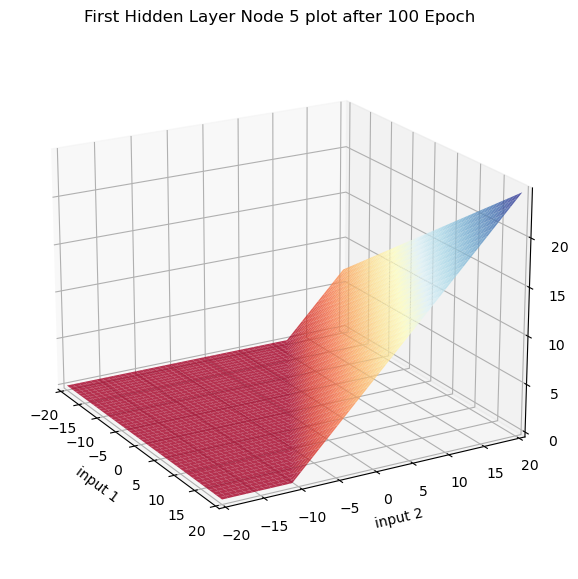

2813/2813 [==============================] - 2s 710us/step


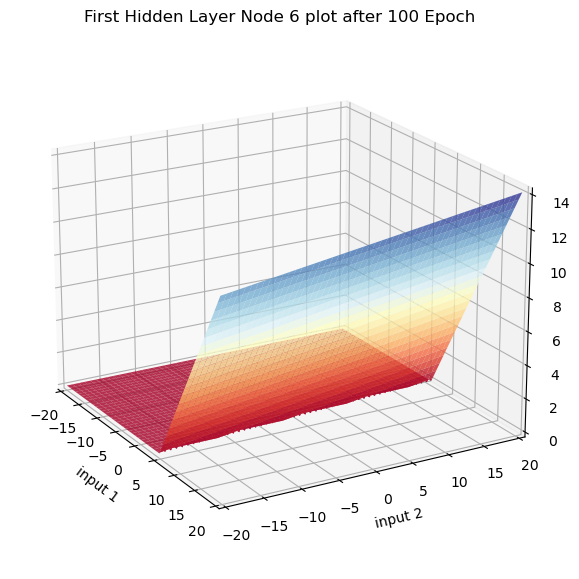

2813/2813 [==============================] - 2s 756us/step


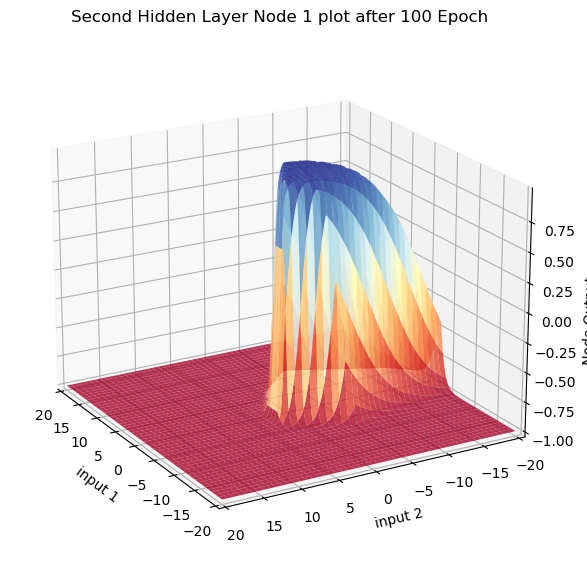

2813/2813 [==============================] - 2s 755us/step


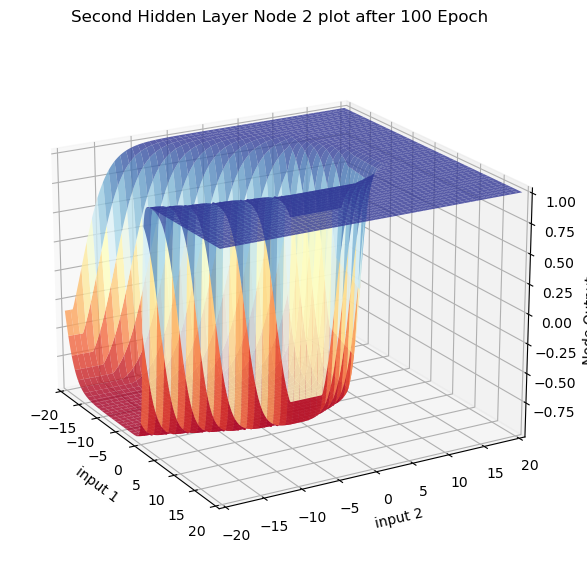

2813/2813 [==============================] - 2s 745us/step


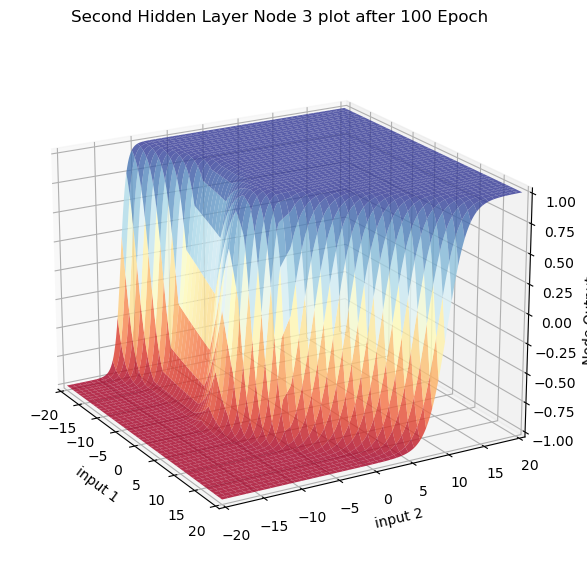

2813/2813 [==============================] - 2s 742us/step


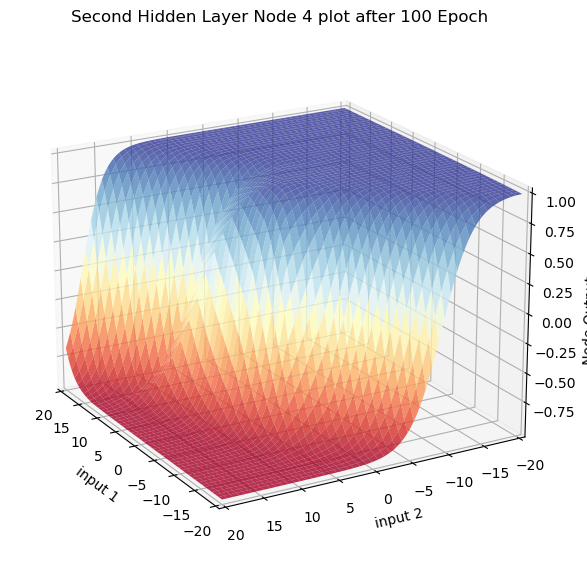

2813/2813 [==============================] - 2s 743us/step


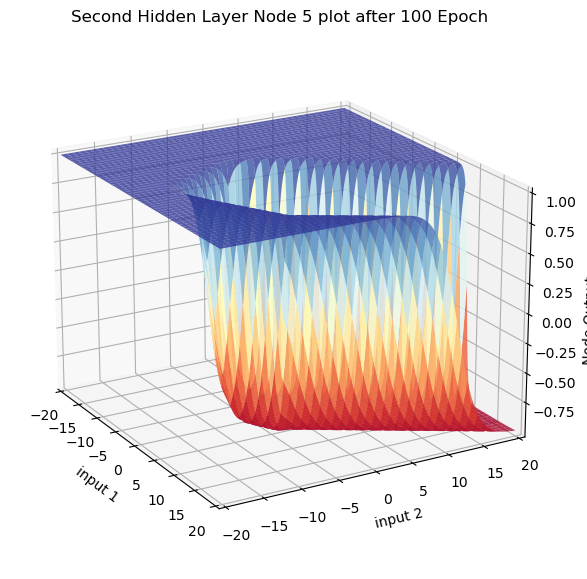

2813/2813 [==============================] - 2s 767us/step


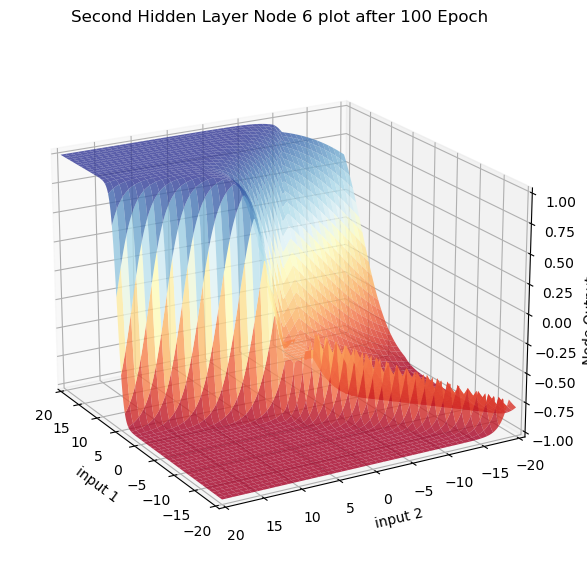

2813/2813 [==============================] - 2s 769us/step


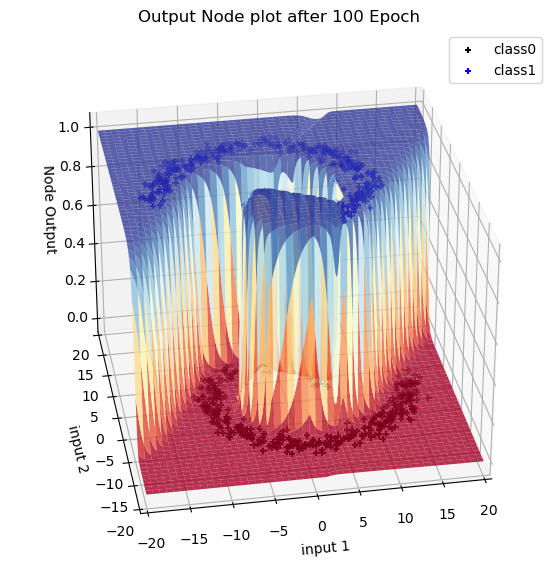

In [237]:
i = '100 Epoch'
# Hidden Layer 1
plot_node_output(hidden_node, 0, 'hidden', f"First Hidden Layer Node 1 plot after {i}")
plot_node_output(hidden_node, 1, 'hidden', f"First Hidden Layer Node 2 plot after {i}")
plot_node_output(hidden_node, 2, 'hidden', f"First Hidden Layer Node 3 plot after {i}")
plot_node_output(hidden_node, 3, 'hidden', f"First Hidden Layer Node 4 plot after {i}")
plot_node_output(hidden_node, 4, 'hidden', f"First Hidden Layer Node 5 plot after {i}")
plot_node_output(hidden_node, 5, 'hidden', f"First Hidden Layer Node 6 plot after {i}")

# Hidden Layer 2
plot_node_output(hidden_node1, 0, 'hidden', f"Second Hidden Layer Node 1 plot after {i}",20,150)
plot_node_output(hidden_node1, 1, 'hidden', f"Second Hidden Layer Node 2 plot after {i}")
plot_node_output(hidden_node1, 2, 'hidden', f"Second Hidden Layer Node 3 plot after {i}")
plot_node_output(hidden_node1, 3, 'hidden', f"Second Hidden Layer Node 4 plot after {i}",20,150)
plot_node_output(hidden_node1, 4, 'hidden', f"Second Hidden Layer Node 5 plot after {i}")
plot_node_output(hidden_node1, 5, 'hidden', f"Second Hidden Layer Node 6 plot after {i}",20,150)

# Output layer
plot_node_output(output_node, 0, 'output', f"Output Node plot after {i}",30,-100)

2813/2813 [==============================] - 2s 796us/step


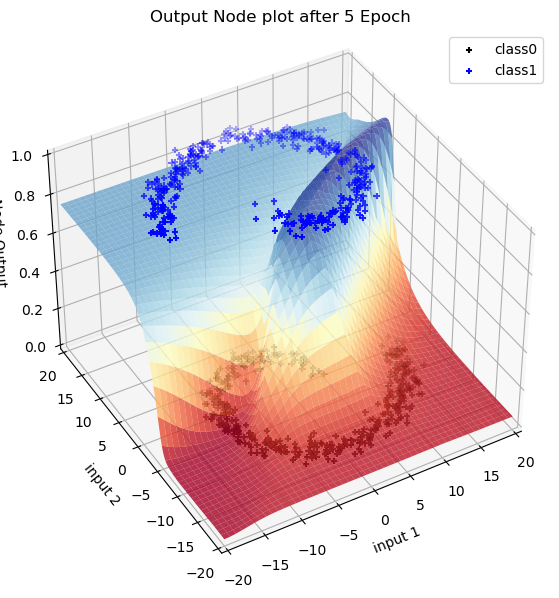

In [106]:
plot_node_output(output_node, 0, (0,1) ,'output', f"Output Node plot after 5 Epoch",40,-120)

## Dataset 2 : 

In [4]:
from keras.utils import to_categorical

In [5]:
Xtrain = pd.read_csv('dataset 2/train_data.csv',header=None)
ytrain = pd.read_csv('dataset 2/train_label.csv',header=None)
ytrainh = to_categorical(ytrain, num_classes=5)

Xval  = pd.read_csv('dataset 2/val_data.csv',header=None)
yval  = pd.read_csv('dataset 2/val_label.csv',header=None)
yvalh = to_categorical(yval, num_classes=5)

Xtest = pd.read_csv('dataset 2/test_data.csv',header=None)
ytest = pd.read_csv('dataset 2/test_label.csv',header=None)
ytesth = to_categorical(ytest, num_classes=5)

In [6]:
i = 500
nodes = [5,10,20,40,80,160,320]
model = []

for node in nodes : 
    sgd = SGD(learning_rate=0.05, momentum=0.9)

    print("Hyperparameter : Number of Nodes : ",node)

    model1 = Sequential()
    model1.add(Dense(units=node, input_dim = 81, activation='relu'))
    model1.add(Dense(units=node, activation='sigmoid'))
    model1.add(Dense(units=5, activation='softmax'))
    model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


    print(f"Epoch Number : {i}")
    model.append(model1.fit(Xtrain, ytrainh, epochs=i, batch_size=10, validation_data=(Xval,yvalh))) 
    print('------------------------------------------------------------------------------------------------------------------------------------------------')
    print('| Actual test begins here : ',model1.evaluate(Xtest, ytesth),' |')
    print('------------------------------------------------------------------------------------------------------------------------------------------------')

Hyperparameter : Number of Nodes :  5
Epoch Number : 500
Epoch 1/500


2023-12-01 16:40:38.630566: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-12-01 16:40:38.630593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Predator
2023-12-01 16:40:38.630601: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Predator
2023-12-01 16:40:38.630694: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2023-12-01 16:40:38.630717: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2023-12-01 16:40:38.630724: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


350/350 [==============================] - 1s 2ms/step - loss: 1.6111 - categorical_accuracy: 0.2180 - val_loss: 1.4965 - val_categorical_accuracy: 0.3590
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 1.3626 - categorical_accuracy: 0.3614 - val_loss: 1.2693 - val_categorical_accuracy: 0.4160
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 1.2738 - categorical_accuracy: 0.4206 - val_loss: 1.2415 - val_categorical_accuracy: 0.4180
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 1.2136 - categorical_accuracy: 0.4549 - val_loss: 1.2278 - val_categorical_accuracy: 0.4260
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 1.1880 - categorical_accuracy: 0.4689 - val_loss: 1.2436 - val_categorical_accuracy: 0.4460
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 1.1758 - categorical_accuracy: 0.4760 - val_loss: 1.2352 - val_categorical_accuracy: 0.4470
Epoch 7/50

In [15]:
i = 500
node = 160

sgd = SGD(learning_rate=0.05, momentum=0.9)

print("Hyperparameter : Number of Nodes : ",node)

model1 = Sequential()
model1.add(Dense(units=node, input_dim = 81, activation='relu'))
model1.add(Dense(units=node, activation='sigmoid'))
model1.add(Dense(units=5, activation='softmax'))
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


print(f"Epoch Number : {i}")
model1.fit(Xtrain, ytrainh, epochs=i, batch_size=10, validation_data=(Xval,yvalh))
print('------------------------------------------------------------------------------------------------------------------------------------------------')
print('| Actual test begins here : ',model1.evaluate(Xtest, ytesth),' |')
print('------------------------------------------------------------------------------------------------------------------------------------------------')

Hyperparameter : Number of Nodes :  160
Epoch Number : 500
Epoch 1/500
350/350 [==============================] - 1s 2ms/step - loss: 1.6309 - categorical_accuracy: 0.2834 - val_loss: 1.3162 - val_categorical_accuracy: 0.3440
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 1.3055 - categorical_accuracy: 0.3806 - val_loss: 1.2388 - val_categorical_accuracy: 0.4260
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 1.2033 - categorical_accuracy: 0.4711 - val_loss: 1.2923 - val_categorical_accuracy: 0.4150
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 1.1300 - categorical_accuracy: 0.5223 - val_loss: 1.2727 - val_categorical_accuracy: 0.4820
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 1.1334 - categorical_accuracy: 0.5314 - val_loss: 1.1100 - val_categorical_accuracy: 0.5390
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 1.0757 - categorical_accuracy: 

KeyboardInterrupt: 

In [95]:
model1.evaluate(Xtest,ytesth)

 1/16 [>.............................] - ETA: 0s - loss: 2.4588 - categorical_accuracy: 0.6250

16/16 [==============================] - 0s 2ms/step - loss: 2.8889 - categorical_accuracy: 0.5780


[2.888908624649048, 0.578000009059906]

In [96]:
a = model1.predict(Xtest)

16/16 [==============================] - 0s 809us/step


In [97]:
predicted_results = np.argmax(a, axis=1) [np.newaxis] .T

In [98]:
t = np.vectorize(int)(ytest.to_numpy())
p = predicted_results
confusion_matrix = np.zeros((5,5))

for j in range(len(t)) :
    p1 = p[j,0]
    t1 = t[j,0]
    confusion_matrix[p1,t1] = confusion_matrix[p1,t1] + 1

print(confusion_matrix)

[[58. 14.  5.  1. 15.]
 [13. 46. 16.  6.  7.]
 [ 3. 23. 55. 23.  7.]
 [ 9. 10. 16. 66.  7.]
 [17.  7.  8.  4. 64.]]
